In [2]:
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import os



In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
# 数据准备： 
# 数据归一化: 归一化(-1, 1)
# 因为生成器的激活函数是thenH激活范围再(-1, 1)
transforms_mnist = transforms.Compose([
    transforms.ToTensor(), # 做(0, 1)归一化, 并且转换为Tensor对象. (channel, height, witch)
    # 然后从(0, 1)转换到(-1, 1)
    transforms.Normalize(0.5, 0.5)
])

# 加载内置数据集:
train_datasets = torchvision.datasets.MNIST(
    "./data_mnist",
    True,
    transform=transforms_mnist,
    download=True
    
)

train_dataloader = DataLoader(train_datasets, batch_size=64, shuffle=True, num_workers=28)


In [5]:
imgs, _ = next(iter(train_dataloader))
imgs.shape # torch.Size([64, 1, 28, 28])

torch.Size([64, 1, 28, 28])

In [6]:
# 生成器模型: 
# 生成网络模型的定义: 
# 生成器的输入: 噪声(长度为100的噪声(随机数符合正态分布)), 输出: 一张符合mnist数据集的图片. 也就是要生成1*28*28的Tesor(图片)
# 这里我们作为最简单的的MLP我们就是用Linear来做. 
# linear1: 100 -> 256
# linear2: 256 -> 512
# linear3: 512 -> 28*28
# 然后经过reshape: 28*28 -> (1, 28, 28)
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.backbone = nn.Sequential(
            nn.Linear(100, 256), nn.ReLU(), 
            nn.Linear(256, 512), nn.ReLU(), 
            nn.Linear(512, 28*28), nn.Tanh(), # 对于生成器最后的激活函数最好使用Tanh, 这样我们可以规范到-1, 1之间.

        )
    def forward(self, X): # X表示长度为100的noise输入. 
        img: torch.Tensor = self.backbone(X)
        img = img.reshape(-1,  28, 28, 1)
        
        return img


In [7]:
X = torch.randn((1, 100))
X = Generator()(X)
X.shape

torch.Size([1, 28, 28, 1])

In [8]:
# 判别器模型: 
# 判别器的输入: 一张图片, 输出二分类的概率. 使用sigmoid最后得到(0,1)之间的概率值. 
# BCE Loss当是二分类问题的时候, 计算交叉熵损失
# 在判别器中一般推荐使用LeakyReLU()函数进行激活, 因为GAN难以训练, 所以为了优化GAN的训练
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.backbone = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(), # 小于0时, 是给出小的斜率. 扩大ReLU函数的范围. 
            nn.Linear(512, 256), nn.LeakyReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, X):
        # X: 1*28*28的进行faltten
        # X = torch.flatten(X, start_dim=)
        X = nn.Flatten()(X)
        X = self.backbone(X)
        # print(X.shape)
        return X

In [9]:
X = torch.randn((1, 1, 28, 28))
X = Discriminator()(X)
print(X.shape)

torch.Size([1, 1])


In [10]:
# 初始化模型, 优化器, 以及损失计算函数:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

gen = Generator().to(device)
dis = Discriminator().to(device)

dis_optim = torch.optim.Adam(dis.parameters(), lr=1e-4)
gen_optim = torch.optim.Adam(gen.parameters(), lr=1e-4)

loss_fn = torch.nn.BCELoss().to(device) # 损失计算函数

cuda:0


In [11]:
# 绘图函数:
def gen_img_plot(model:nn.Module, epoch, test_input):
    pred = torch.squeeze(model(test_input)).detach().cpu() # 输出预测值.
    # squeeze删除指定维度
    fig = plt.figure(figsize=(4, 4))
    for i in range(pred.shape[0]): # 绘制子图.
        plt.subplot(4, 4, i+1)
        plt.imshow((pred[i]+1)/2) # pred预测是经过tanh的, 最后的结果是-1, 1, 但是这样没办法绘图, 所以我们需要归一化到0, 1之间.
        plt.axis('off')
    plt.show()
    


In [12]:
test_input = torch.randn(size=(16, 100), device=device)

epoch 9


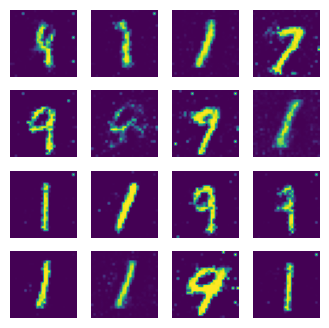

epoch 19


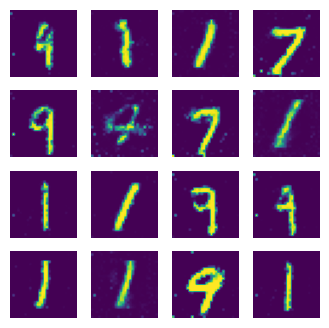

epoch 29


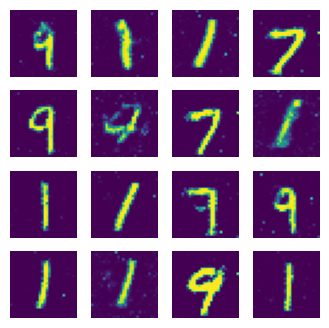

epoch 39


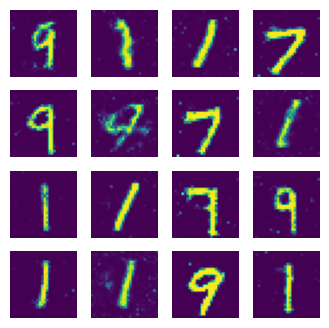

epoch 49


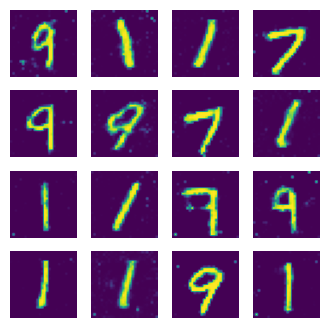

In [14]:
# GAN训练:
D_loss = []
G_loss = []

num_epoch = 50
# 训练: 
for epoch in range(num_epoch):
    D_epoch_loss = 0
    G_epoch_loss = 0
    # count = len()
    for idx, (features, labels) in enumerate(train_dataloader):
        features = features.to(device)
        size = features.size(0)
        random_noise = torch.randn(size, 100, device=device)

        dis_optim.zero_grad()
        real_output = dis(features) # 对判别器输出真实的图片. 
        
        d_real_loss = loss_fn(real_output, torch.ones_like(real_output)) # 我们希望真实的图片, 输出全为1. 
        # 判别器在真实图像上的损失. 
        d_real_loss.sum().backward()

        # 在生成图像上计算损失:
        fake_img = gen(random_noise)
        fake_output = dis(fake_img.detach()) # 截断, 因为我们是要训练判别器, 而不是生成器. 所以要detach()
        d_fake_loss = loss_fn(fake_output, torch.zeros_like(fake_output)) # 优化目标是判别器. 我们不训练生成器. 
        # 在生成图像上, 我们需要判别器判别生成图像都是全0. 得到判别器在生成图像的损失.
        d_fake_loss.backward()


        d_loss = d_real_loss + d_fake_loss # 加起来. 
        dis_optim.step() # 优化. 

        gen_optim.zero_grad()
        fake_output = dis(fake_img) # 接下来我们要优化生成器, 所以不进行detach. 
        gen_loss = loss_fn(fake_output, torch.ones_like(real_output ))
        # 生成器的损失, 我们希望生成的图像, 被判别为1. 
        gen_loss.backward()
        gen_optim.step()

        # 累加梯度:
        with torch.no_grad():
            D_epoch_loss += d_loss
            G_epoch_loss += gen_loss
    with torch.no_grad():
        D_epoch_loss /= (idx+1)
        D_epoch_loss /= (idx+1)
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        os.system("clear")
        if (epoch+1) % 10 == 0:
            print("epoch", epoch)
            gen_img_plot(gen, epoch, test_input)


In [26]:
import os

pid = os.getpid()
!kill -9 $pid


: 

: 

4001948